<a href="https://colab.research.google.com/github/Anil1331/Style-Transfer/blob/master/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir vgg
from google.colab import files
uploaded = files.upload()

In [28]:
import os, requests
import sys
import time
import numpy as np
import scipy.io
import scipy.misc
import skimage.transform
import tensorflow as tf
import matplotlib.pyplot as plt

style_img = "style.jpg"
content_img = "content.jpg"
width = 800
height = 600
num_channels = 3
noise_ratio = 0.6
num_iterations = 100
beta = 7.5
alpha = 100
gamma = 200
mean = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

def download_vgg():
  url = "http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat"
  filename = "vgg/"+"vgg.mat"
  if(not os.path.exists(filename)):
    r = requests.get("http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat")
    open(filename, "wb").write(r.content)
  vgg = scipy.io.loadmat(filename)
  return vgg

def get_weights(layer, vgg):
  wb = vgg["layers"][0][layer][0][0][2]
  w = wb[0][0]
  b = wb[0][1]
  return w, b

def load_image(path):
    image = scipy.misc.imread(path)
    image = 255 * skimage.transform.resize(image, (height, width, num_channels))
    image = np.reshape(image, ((1,) + image.shape))
    image = image - mean
    return image

def conv_layer(input_layer, layer, vgg):
  w, b = get_weights(layer, vgg)
  w = tf.constant(w)
  b = tf.constant(np.reshape(b, (b.size)))
  return tf.nn.conv2d(input_layer, filter=w, strides=[1, 1, 1, 1], padding='SAME') + b

def batch_conv_pool(input_layer, input_layer_count, num_conv_layers, nn, vgg):  
  for i in range(num_conv_layers):
    conv = tf.nn.relu(conv_layer(input_layer, input_layer_count, vgg))
    input_layer_count = input_layer_count + 2
    input_layer = conv
    nn.append(conv)
  out = tf.nn.avg_pool(input_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
  nn.append(out)
  input_layer_count = input_layer_count + 1
  return out, input_layer_count

def create_nn(height, width, num_channels, vgg):
  nn = []
  input_data = tf.Variable(np.zeros((1, height, width, num_channels)), dtype = 'float32')
  nn.append(input_data)
  batch1, count = batch_conv_pool(input_data, 0, 2, nn, vgg)
  batch2, count = batch_conv_pool(batch1, count, 2, nn, vgg)
  batch3, count = batch_conv_pool(batch2, count, 4, nn, vgg)
  batch4, count = batch_conv_pool(batch3, count, 4, nn, vgg)
  batch5, count = batch_conv_pool(batch4, count, 4, nn, vgg)
  return nn

def gmm(layer, wh, ch):
  reshaped_layer = tf.reshape(layer, (wh, ch))
  return tf.matmul(tf.transpose(reshaped_layer), reshaped_layer)

def get_style_loss(sess, nn):
  style_layers = [1, 4, 7, 12, 17]
  style_weights = [0.5, 1, 1.5, 3, 4]
  total_loss = 0
  for i, st in enumerate(style_layers):
    layer = nn[st]
    w, h, ch = layer.shape[1].value, layer.shape[2].value, layer.shape[3].value
    wh = w*h
    current = sess.run(layer)
    gmm_c = gmm(current, wh, ch)
    gmm_l = gmm(layer, wh, ch)
    loss = (1/(4 * ch**2 * wh**2)) * tf.reduce_sum(tf.pow(gmm_c - gmm_l, 2))
    total_loss = total_loss + loss*style_weights[i]
  return total_loss

def get_content_loss(sess, nn):
  layer = nn[21]
  w, h, ch = layer.shape[1].value, layer.shape[2].value, layer.shape[3].value
  wh = w*h
  current = sess.run(layer)
  loss = (1 / (4 * ch * wh)) * tf.reduce_sum(tf.pow(layer - current, 2))
  return loss

def get_variatonal_loss(sess, nn):
    return tf.reduce_sum(tf.image.total_variation(nn[0]))
  
def get_input_image(content_image, height, width, num_channels, noise_ratio):
    noise_image = np.random.uniform(-20, 20,
            (1, height, width, num_channels)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image  

def save_image(path, image):
    image = image + mean
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)  
  
def show_image(image):
    image = image + mean
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    plt.imshow(image)
    plt.close()  
  
def run_training():
  with tf.Session() as sess:
    vgg = download_vgg()
    content_image = load_image(content_img)
    style_image = load_image(style_img)
    nn = create_nn(height, width, num_channels, vgg)
    input_image = get_input_image(content_image, height, width, num_channels, noise_ratio)

    sess.run(tf.global_variables_initializer())
    sess.run(nn[0].assign(style_image))
    style_loss = get_style_loss(sess, nn)
    sess.run(nn[0].assign(content_image))
    content_loss = get_content_loss(sess, nn)
    sess.run(nn[0].assign(input_image))
    total_variational_loss = get_variatonal_loss(sess, nn)

    total_loss = beta * content_loss + alpha * style_loss + gamma * total_variational_loss
    optimizer = tf.train.AdamOptimizer(2.0)
    train_step = optimizer.minimize(total_loss)
    sess.run(tf.global_variables_initializer())
    sess.run(nn[0].assign(input_image))  
    for i in range(1, num_iterations+1):
        sess.run(train_step)
        if i % 20 == 0:
            Jt, Jc, Js, Jv = sess.run([total_loss, content_loss, style_loss, total_variational_loss])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            print("total variational loss = ", str(Jv))  
            
        if i % 100 == 0:
            generated_image = sess.run(nn[0])
            save_image(str(i) + ".jpg", generated_image)
            save_image('generated_image.jpg', generated_image)

            show_image(generated_image)            
            
    sess.close()        
          
run_training()          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Iteration 20 :
total cost = 60807782000.0
content cost = 0.25630435
style cost = 533909630.0
total variational loss =  37084090.0
Iteration 40 :
total cost = 23125350000.0
content cost = 0.2777457
style cost = 152207700.0
total variational loss =  39522904.0
Iteration 60 :
total cost = 15421902000.0
content cost = 0.2776948
style cost = 80130020.0
total variational loss =  37044500.0
Iteration 80 :
total cost = 12200112000.0
content cost = 0.28303185
style cost = 54168860.0
total variational loss =  33916132.0
Iteration 100 :
total cost = 10393956000.0
content cost = 0.2881877
style cost = 41540108.0
total variational loss =  31199728.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


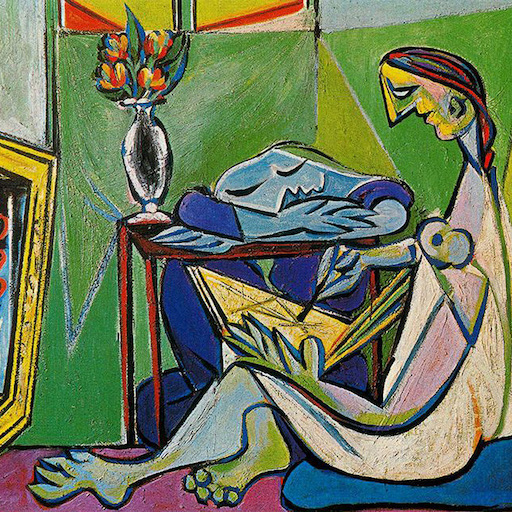

In [35]:
from IPython.display import Image
Image('generated_image.jpg')